In [1]:
setwd("/mnt/c/git_repos/blood_microbial_signatures")
require(tidyverse)
require(ggplot2)
require(data.table)
require(egg)
require(foreach)
require(doParallel)
registerDoParallel(cores=8)

Loading required package: tidyverse

Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tibble’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.3”
Warning message:
“package ‘readr’ was built under R version 4.1.3”
Warning message:
“package ‘purrr’ was built under R version 4.1.3”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
Warning message:
“package ‘stringr’ was built under R version 4.1.3”
Warning messa

### Parameters for simulations

In [2]:
meta <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv") %>%
    as_tibble()

get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}

meta_cols <- get_meta_cols(meta)
# meta_cols <- c("extraction_kit", "site_supplying_sample", "instrument_id")

In [3]:
median(meta$error_rate)
med_library_depth <- median(meta$raw_total_sequences)
# med_microbial_depth <- median(rowSums(species_df %>% select(-npm_research_id, -unclassified, -"Homo sapiens")))
med_library_depth
median(meta$insert_size_average)


[1] 0.006570216

[1] 373464307

[1] 317.9

# Simulation analysis

### 10 species simulation (no human)

In [4]:
tp <- c("Yersinia enterocolitica", "Leclercia adecarboxylata", "Moraxella osloensis", 
        "Pasteurella multocida", "Streptococcus pneumoniae", "Candida albicans", 
        "Actinomyces viscosus", "Staphylococcus epidermidis", "Torque teno virus", 
        "Human betaherpesvirus 6A")

In [5]:
otu_to_RA <- function(df) {
    row_names <- df$sample
    RA_df <- t(apply(df %>% select(-sample, -unclassified), 1, function(x) {x / sum(x)}))
    
    return(cbind(data.frame(sample = row_names), as.data.frame(RA_df, check.names = F)))
}

parse_df <- function(sim_df) {
    parsed_sim <- sim_df %>% 
        pivot_longer(!sample, names_to = "taxa", values_to = "abundance") %>%
        filter(abundance != 0) %>%
        mutate(classification = case_when(taxa == "unclassified" ~ "Unclassified", 
                                          taxa %in% tp ~ "TP", 
                                          TRUE ~ "FP"),
               sample = gsub("simulated.human_", "", sample)) %>%
        mutate(sample = gsub("_microbe", "", sample)) %>%
        mutate(sample = gsub("0", "", sample)) %>%
        mutate(microbial_reads = case_when(sample == "1e-6" ~ "(370 reads)",
                                           sample == "1e-5" ~ "(3,730 reads)",
                                           sample == "1e-4" ~ "(37,332 reads)",
                                           sample == "1e-3" ~ "(373,368 reads)")) %>%
        mutate(sample = paste(sample, microbial_reads)) %>%
        arrange(desc(classification))

    parsed_sim <- parsed_sim %>% mutate(taxa = factor(taxa, levels = unique(parsed_sim$taxa)))
}

In [6]:
sim_df <- fread("results/simulation_out/07_abundance_matrix/abundance_matrix.S.tsv")
sim_RA <- otu_to_RA(sim_df)
parsed_sim <- parse_df(sim_df)
parsed_sim_RA <- parse_df(sim_RA)

Warning message:
“Removed 774 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 774 rows containing missing values (`geom_bar()`).”


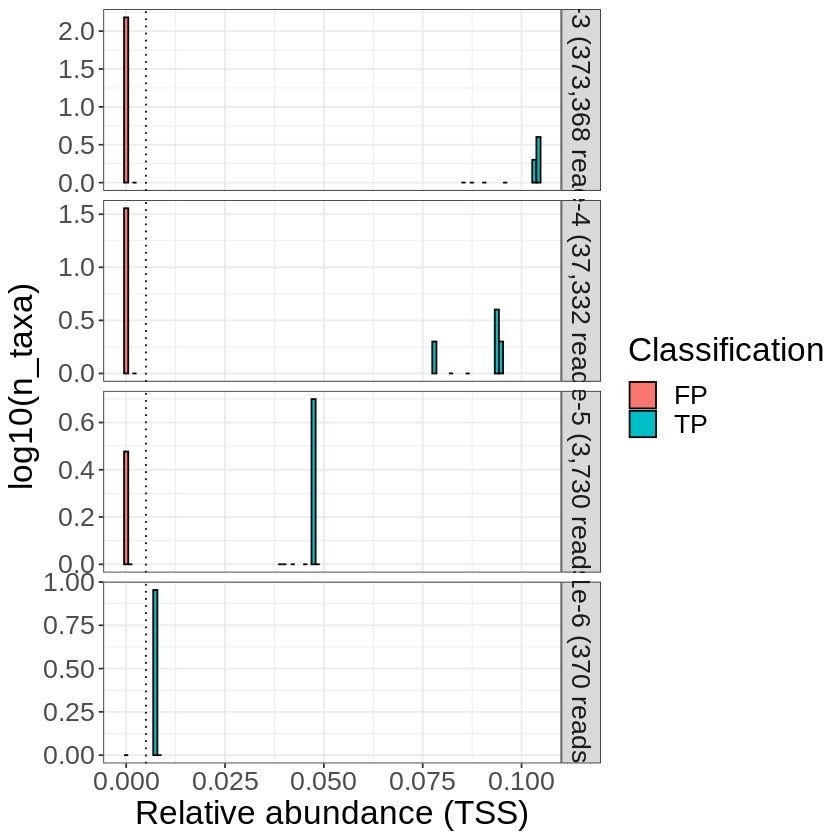

In [10]:
PA_threshold <- 0.005

plot_df <- parsed_sim_RA %>% 
    filter(classification != "Unclassified",
           taxa != "Homo sapiens")

plot_df %>% fwrite("results/figure_source_data_nat_micro/abundance_distribution_fp_tp.csv")

RA_plt <- plot_df %>%
    ggplot(aes(x = abundance, fill = classification)) +
    theme_bw() +
    theme(text = element_text(size = 20)) +
    geom_histogram(bins = 100, 
                   aes(y = log(..count.., base = 10)),
                   color = "black") +
    facet_grid(rows = vars(sample), scales = "free") +
    labs(x = "Relative abundance (TSS)", y = "log10(n_taxa)", fill = "Classification") +
    geom_vline(xintercept = PA_threshold, color = "black", linetype = "dotted")

# combined <- ggpubr::ggarrange(read_plt, RA_plt, ncol = 2, common.legend = T)
combined <- RA_plt
combined
ggsave("results/simulation_out/abundance_distribution_fp_tp.pdf", 
       dpi = 600, 
       plot = combined, 
       width = 20, height = 7)

#### No. of assigned species per sample

In [ ]:
micro_sim <- sim_df %>% select(-sample, -unclassified, -"Homo sapiens")
rowsum_sim <- tibble(sample = sim_df$sample, rowsums = rowSums(micro_sim))

rowsum_sim


sim_prev <- sim_df %>%
    select(-sample, -"Homo sapiens", -unclassified)

sim_prev[sim_prev <= 0] <- 0
sim_prev[sim_prev > 0] <- 1

sim_prev <- tibble(sample = sim_df$sample, n_assigned = rowSums(sim_prev))
    
sim_prev %>%
    left_join(rowsum_sim) %>%
    ggplot(aes(x = rowsums, y = n_assigned)) +
    geom_point() 

#### Distribution of read counts for FP/TP

In [ ]:
micro_sim <- sim_df %>% select(-sample, -unclassified, -"Homo sapiens")
rowsum_sim <- tibble(sample = sim_df$sample, rowsums = rowSums(micro_sim))

rowsum_sim


sim_prev <- sim_df %>%
    select(-sample, -"Homo sapiens", -unclassified)

sim_prev[sim_prev <= 0] <- 0
sim_prev[sim_prev > 0] <- 1

sim_prev <- tibble(sample = sim_df$sample, n_assigned = rowSums(sim_prev))
    
sim_prev %>%
    left_join(rowsum_sim) %>%
    ggplot(aes(x = rowsums, y = n_assigned)) +
    geom_point() 



In [ ]:
med_library_depth

In [ ]:
1e-7

In [ ]:
1e-7*med_library_depth

In [ ]:
parsed_sim_RA %>%
    filter(abundance < 0.05, classification == "TP")

### Read counts for each microbial depth

In [ ]:
plots <- foreach(sim_run = c("simulated.10e-3", "simulated.10e-4", "simulated.10e-5", "simulated.10e-6")) %do% {
    parsed_sim %>%
        filter(sample == sim_run) %>%
        ggplot(aes(x = taxa, y = read_count, fill = classification)) +
        geom_bar(stat = "identity") +
        labs(x = "Taxa", y = "Reads assigned", fill = "Taxon classification") +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        facet_grid(cols = vars(sample))
}

In [ ]:
plots